<a href="https://colab.research.google.com/github/quantum-intelligence/computational-physics/blob/main/CP_Lecture19b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Computational Physics
###Lecture 19b
###Intro to quantum computing using Qiskit

You will need an API key to run this tutorial.
Please go to the link below to create an account. Capture your API token from your profile page after you've created an account.

https://quantum.ibm.com/account

**Hello World**

Work through the example below:

The code below is adapted from:
https://quantum.cloud.ibm.com/docs/en/guides/hello-world


#Create and run a simple quantum program

The four steps to writing a quantum program using Qiskit patterns are:

1.   Map the problem to a quantum-native format.
2.   Optimize the circuits and operators.
3.   Execute using a quantum primitive function.
4.   Analyze the results.








####Install required packages

In [ ]:
%%capture
!pip install qiskit_ibm_runtime

In [ ]:
%%capture
!pip install qiskit qiskit-nature qiskit-algorithms qiskit-aer

In [ ]:
%%capture
!pip install pylatexenc

### Connect to the quantum computing resources:

You have the option to use different IBM quantum computers (may be limited by access) and to use a simulator.

In [ ]:
token = "<your-API-token>"

In [ ]:
import os
from qiskit_ibm_runtime import QiskitRuntimeService
save_account_credentials = False
use_rpi_rensselaer = False

if save_account_credentials:
    # Set your token temporarily (only lasts for this session)
    os.environ["QISKIT_IBM_TOKEN"] = token
    if use_rpi_rensselaer:
      # Load the token from the environment
      QiskitRuntimeService.save_account(
          channel='ibm_quantum',
          token=os.environ["QISKIT_IBM_TOKEN"],
          instance='rpi-rensselaer/research/rhone',
          overwrite=True)
    else:
      # Load the token from the environment
      QiskitRuntimeService.save_account(
          channel='ibm_quantum',
          token=os.environ["QISKIT_IBM_TOKEN"],
          instance='ibm-q/open/main',
          overwrite=True)
    service = QiskitRuntimeService()

# Note:
# Save your credentials on disk may only work locally - not on colab
# You can try running this cell with "save_account_credentials = True" using jupyter notebook on your PC

In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService
save_account_credentials = False
use_rpi_rensselaer = False

if save_account_credentials==False:
  # Use your access to rpi_rensselaer!
  if use_rpi_rensselaer:
    # Load the token from the environment
    service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance='rpi-rensselaer/research/rhone',
        token=token,
    )
  else:
    # Load the token from the environment
    service = QiskitRuntimeService(
        channel='ibm_quantum',
        instance='ibm-q/open/main',
        token=token,
    )


<ipython-input-6-5f021ba8e295>:15: DeprecationWarning: The "ibm_quantum" channel option is deprecated and will be sunset on 1 July. After this date, ibm_cloud will be the only valid channel. For information on migrating to the new IBM Quantum Platform on the "ibm_cloud" channel, review the migration guide https://quantum.cloud.ibm.com/docs/migration-guides/classic-iqp-to-cloud-iqp .
  service = QiskitRuntimeService(


### Step 1. Map the problem to a quantum-native format

In a quantum program, quantum circuits are the native format in which to represent quantum instructions, and operators represent the observables to be measured. When creating a circuit, you'll usually create a new QuantumCircuit object, then add instructions to it in sequence.

The following code cell creates a circuit that produces a Bell state, which is a state wherein two qubits are fully entangled with each other.

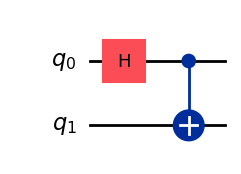

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.transpiler import generate_preset_pass_manager
from qiskit_ibm_runtime import EstimatorV2 as Estimator

# Create a new circuit with two qubits
qc = QuantumCircuit(2)

# Add a Hadamard gate to qubit 0
qc.h(0)

# Perform a controlled-X gate on qubit 1, controlled by qubit 0
qc.cx(0, 1)

# Return a drawing of the circuit using MatPlotLib ("mpl"). This is the
# last line of the cell, so the drawing appears in the cell output.
# Remove the "mpl" argument to get a text drawing.
qc.draw("mpl")

When creating quantum circuits, you must also consider what type of data you want returned after execution. Qiskit provides two ways to return data: you can obtain a probability distribution for a set of qubits you choose to measure, or you can obtain the expectation value of an observable. Prepare your workload to measure your circuit in one of these two ways with Qiskit primitives (explained in detail in Step 3).

This example measures expectation values by using the qiskit.quantum_info submodule, which is specified by using operators (mathematical objects used to represent an action or process that changes a quantum state). The following code cell creates six two-qubit Pauli operators: IZ, IX, ZI, XI, ZZ, and XX

If the state is entangled, then the measurement of
⟨Z$_1$ Z$_0$⟩ should be 1. That is, we can obtain information about the correlation between qubit 1 and qubit 0.

In [ ]:
# Set up six different observables.
observables_labels = ["IZ", "IX", "ZI", "XI", "ZZ", "XX"]
observables = [SparsePauliOp(label) for label in observables_labels]

### Step 2. Optimize the circuits and operators

When executing circuits on a device, it is important to optimize the set of instructions that the circuit contains and minimize the overall depth (roughly the number of instructions) of the circuit. This ensures that you obtain the best results possible by reducing the effects of error and noise. Additionally, the circuit's instructions must conform to a backend device's Instruction Set Architecture (ISA) and must consider the device's basis gates and qubit connectivity.

The following code instantiates a real device to submit a job to and transforms the circuit and observables to match that backend's ISA. It requires that you have already saved your credentials.

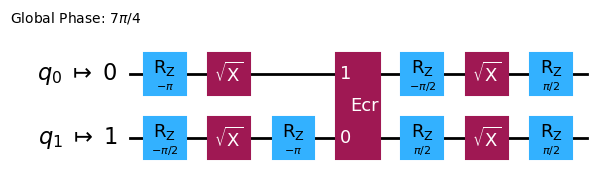

In [ ]:
backend = service.least_busy(simulator=False, operational=True)

# Convert to an ISA circuit and layout-mapped observables.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(qc)

isa_circuit.draw("mpl", idle_wires=False)

### Step 3. Execute using the quantum primitives

Quantum computers can produce random results, so you usually collect a sample of the outputs by running the circuit many times. You can estimate the value of the observable by using the Estimator class. Estimator is one of two primitives; the other is Sampler, which can be used to get data from a quantum computer. These objects possess a run() method that executes the selection of circuits, observables, and parameters (if applicable), using a primitive unified bloc (PUB).

In [ ]:
# Construct the Estimator instance.

estimator = Estimator(mode=backend)
estimator.options.resilience_level = 1
estimator.options.default_shots = 5000

mapped_observables = [
    observable.apply_layout(isa_circuit.layout) for observable in observables
]

# One pub, with one circuit to run against five different observables.
job = estimator.run([(isa_circuit, mapped_observables)])

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

>>> Job ID: d02kse5nhqag008vfey0


After a job is submitted, you can wait until either the job is completed within your current python instance, or use the job_id to retrieve the data at a later time.

After the job completes, examine its output through the job's result() attribute.

In [ ]:
# This is the result of the entire submission.  You submitted one Pub,
# so this contains one inner result (and some metadata of its own).
job_result = job.result()

# This is the result from our single pub, which had six observables,
# so contains information on all six.
pub_result = job.result()[0]

In [ ]:
job_result

PrimitiveResult([PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})], metadata={'dynamical_decoupling': {'enable': False, 'sequence_type': 'XX', 'extra_slack_distribution': 'middle', 'scheduling_method': 'alap'}, 'twirling': {'enable_gates': False, 'enable_measure': True, 'num_randomizations': 'auto', 'shots_per_randomization': 'auto', 'interleave_randomizations': True, 'strategy': 'active-accum'}, 'resilience': {'measure_mitigation': True, 'zne_mitigation': False, 'pec_mitigation': False}, 'version': 2})

In [ ]:
pub_result

PubResult(data=DataBin(evs=np.ndarray(<shape=(6,), dtype=float64>), stds=np.ndarray(<shape=(6,), dtype=float64>), ensemble_standard_error=np.ndarray(<shape=(6,), dtype=float64>), shape=(6,)), metadata={'shots': 5024, 'target_precision': 0.01414213562373095, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32})

### Alternative: using a simulator

When you run your quantum program on a real device, your workload must wait in a queue before it runs. To save time, you can instead use the following code to run this small workload on the fake_provider with the Qiskit Runtime local testing mode. Note that this is only possible for a small circuit. When you scale up in the next section, you will need to use a real device.

In [ ]:
run_experiment_using_simulator = False
if run_experiment_using_simulator:
  # Use the following code instead if you want to run on a simulator:

  from qiskit_ibm_runtime.fake_provider import FakeAlmadenV2
  backend = FakeAlmadenV2()
  estimator = Estimator(backend)

  # Convert to an ISA circuit and layout-mapped observables.

  pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
  isa_circuit = pm.run(qc)
  mapped_observables = [
      observable.apply_layout(isa_circuit.layout) for observable in observables
  ]

  job = estimator.run([(isa_circuit, mapped_observables)])
  result = job.result()

  # This is the result of the entire submission.  You submitted one Pub,
  # so this contains one inner result (and some metadata of its own).

  job_result = job.result()

  # This is the result from our single pub, which had five observables,
  # so contains information on all five.

  pub_result = job.result()[0]
  print(job_result)
  print(pub_result)


### Step 4. Analyze the results

The analyze step is typically where you might postprocess your results using, for example, measurement error mitigation or zero noise extrapolation (ZNE). You might feed these results into another workflow for further analysis or prepare a plot of the key values and data. In general, this step is specific to your problem. For this example, plot each of the expectation values that were measured for our circuit.

The expectation values and standard deviations for the observables you specified to Estimator are accessed through the job result's PubResult.data.evs and PubResult.data.stds attributes. To obtain the results from Sampler, use the PubResult.data.meas.get_counts() function, which will return a dict of measurements in the form of bitstrings as keys and counts as their corresponding values.

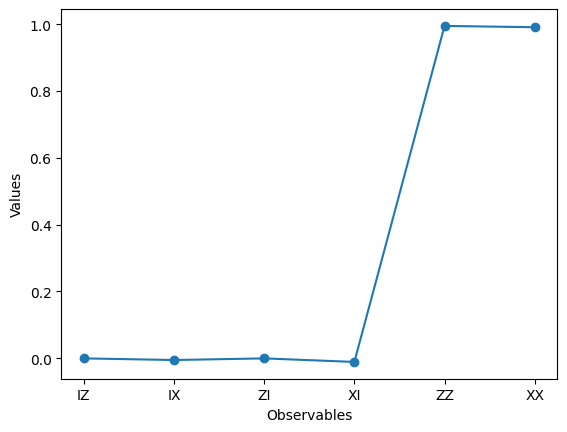

In [ ]:
# Plot the result
from matplotlib import pyplot as plt

values = pub_result.data.evs

errors = pub_result.data.stds

# plotting graph
show_error_bars = False
if show_error_bars:
  plt.errorbar(observables_labels, values, yerr=errors, fmt="-o",markersize=2,linewidth=1)
else:
  plt.plot(observables_labels, values, "-o")
plt.xlabel("Observables")
plt.ylabel("Values")
plt.show()

Notice that for qubits 0 and 1, the independent expectation values of both X and Z are 0, while the correlations (XX and ZZ) are 1. This is a hallmark of quantum entanglement.

# QUESTIONS:
* What are the outputs from the above code:
  * Discuss the results with your neighbours
* Repeat the above analysis for three qubits  
* See the "Hello World" example below to scale up to n qubits

  * https://quantum.cloud.ibm.com/docs/en/guides/hello-world


<Enter answer here>